In [1]:
%matplotlib inline

In [2]:
data_dir='/scr/ilz1/cbspython_surf/data/'

## Working with surface data (if pretty pictures are not enough..)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from vtk_rw import read_vtk, write_vtk

### Simplifying a high resolution mesh

Is a complex task, maybe not the right place to reinvent the wheel. There are good softwares to do this, like Meshlab (http://meshlab.sourceforge.net/)

**But Python can still help us**
* with changing between formats (e.g. vtk to ply https://github.com/juhuntenburg/brainsurfacescripts/blob/master/vtk2ply.py)
* with checking how good the algorithm perfomed / figuring out the best settings
* with mapping from one data to the other and from volumes to the surface
* ...


### Quality assessment of simplified mesh

https://github.com/juhuntenburg/brainsurfacescripts/blob/master/meshstats.py

In [5]:
from meshstats import edges_areas_angles, meshstats

In [6]:
# reading in the data
orig_file=data_dir + 'complex_mesh_rh.vtk'
simple_file = data_dir + 'simple_mesh_rh.vtk'
v_orig, f_orig, d_orig = read_vtk(orig_file)
v_simple, f_simple, d_simple = read_vtk(simple_file)

**NOTE: the simple mesh does not contain data!**

In [7]:
# calculating edge lengths, face areas and angles and some stats on these measures
edges_orig, areas_orig, angles_orig =edges_areas_angles(v_orig, f_orig)
m_area_orig,s_area_orig,z_area_orig=meshstats(areas_orig)
m_edge_orig,s_edge_orig,z_edge_orig=meshstats(edges_orig)
m_angle_orig,s_angle_orig,z_angle_orig=meshstats(angles_orig)

In [8]:
# same for simplified mesh
edges_simple, areas_simple, angles_simple=edges_areas_angles(v_simple, f_simple)
m_area_simple,s_area_simple,z_area_simple=meshstats(areas_simple)
m_edge_simple,s_edge_simple,z_edge_simple=meshstats(edges_simple)
m_angle_simple,s_angle_simple,z_angle_simple=meshstats(angles_simple)

In [9]:
metrics = [[v_orig.shape[0], f_orig.shape[0], m_edge_orig, s_edge_orig, 
            m_area_orig, s_area_orig, m_angle_orig, s_angle_orig]]
metrics.append([v_simple.shape[0],f_simple.shape[0],m_edge_simple,s_edge_simple, 
                m_area_simple, s_area_simple, m_angle_simple, s_angle_simple])

metrics_df = pd.DataFrame(metrics, index=['orig', 'simple'], 
                          columns=['# vertex', '# face', 
                                   'mean edge', 'sdv edge', 
                                   'mean area', 'sdv area',
                                   'mean angle', 'sdv angle'])

metrics_df

,# vertex,# face,mean edge,sdv edge,mean area,sdv area,mean angle,sdv angle
orig,81359,162550,1.112992,0.413033,0.480343,0.276707,1.366764,0.650021
simple,7472,14776,3.704414,1.414911,5.246941,3.008410,1.399411,0.679548


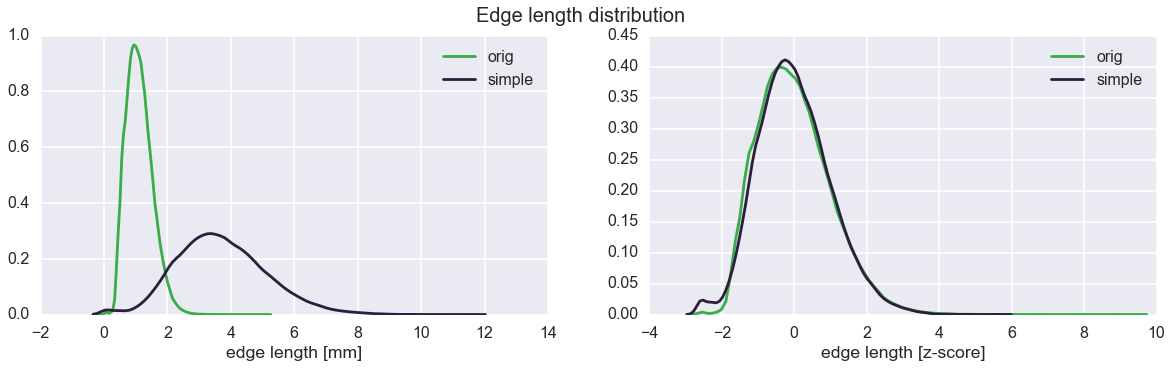

In [17]:
sns.set_context('poster')
fig = plt.figure(figsize=(20,5))
plt.suptitle('Edge length distribution', fontsize=20)
ax1=fig.add_subplot(121)
sns.distplot(edges_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(edges_simple, hist = False, label='simple', color=sns.cubehelix_palette(3)[2])
plt.xlabel('edge length [mm]')

ax2=fig.add_subplot(122)
sns.distplot(z_edge_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(z_edge_simple, hist = False, label='simple', color=sns.cubehelix_palette(3)[2])
plt.xlabel('edge length [z-score]')

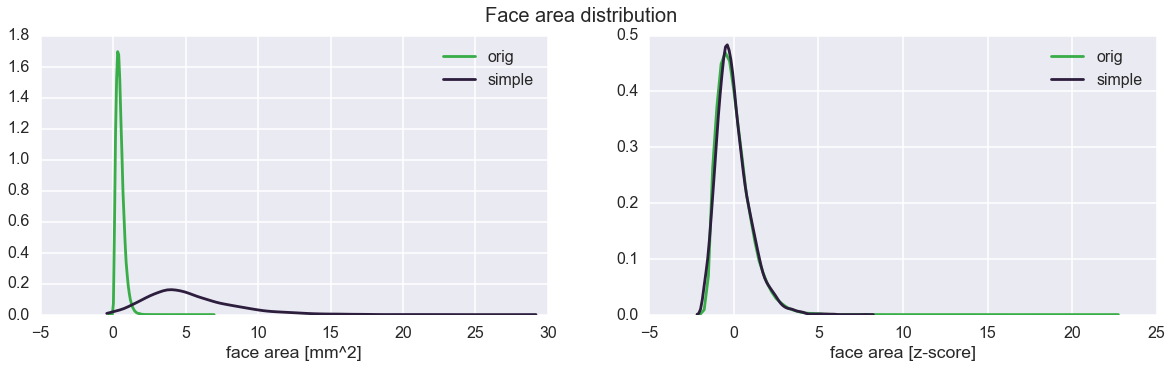

In [18]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Face area distribution', fontsize=20)
ax1=fig.add_subplot(121)
sns.distplot(areas_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(areas_simple, hist = False, label='simple', color=sns.cubehelix_palette(3)[2])
plt.xlabel('face area [mm^2]')

ax2=fig.add_subplot(122)
sns.distplot(z_area_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(z_area_simple, hist = False, label='simple', color=sns.cubehelix_palette(3)[2])
plt.xlabel('face area [z-score]')

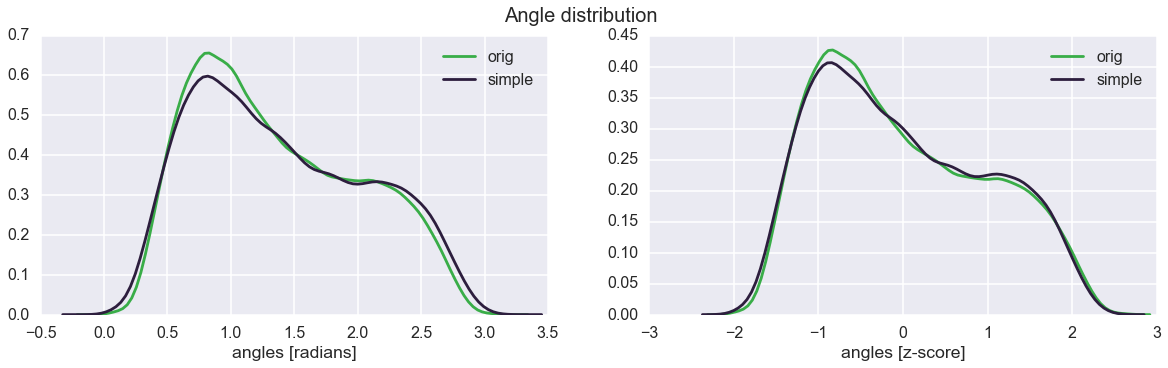

In [19]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Angle distribution', fontsize=20)
ax1=fig.add_subplot(121)
sns.distplot(angles_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(angles_simple, hist = False, label='simple', color=sns.cubehelix_palette(3)[2])
plt.xlabel('angles [radians]')

ax2=fig.add_subplot(122)
sns.distplot(z_angle_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(z_angle_simple, hist = False, label='simple', color=sns.cubehelix_palette(3)[2])
plt.xlabel('angles [z-score]')

### Mapping between high and low resolution mesh

In [20]:
from scipy import spatial

In [21]:
# find the vertices on the high resolution mesh, that are closest to the ones on the low resolution mesh
inaccuracy, mapping  = spatial.KDTree(v_orig).query(v_simple, k=1)

In [22]:
mapping.shape

(7472,)

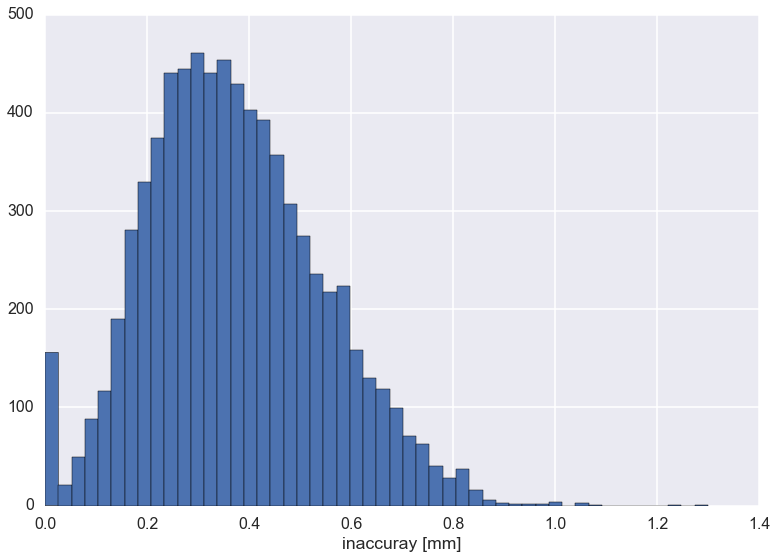

In [23]:
# check inaccuracy
plt.hist(inaccuracy, bins=50);
plt.xlabel('inaccuray [mm]')

In [25]:
# get the data at these vertices and write it on the low resolution mesh
data_simple = d_orig[mapping]
write_vtk('/tmp/simple_mesh_rh_data.vtk', v_simple, f_simple, data_simple)

Ideally, one would not want to sample only from the closest vertex on the highres mesh but from all vertices in the area. More on this here:
https://github.com/juhuntenburg/brainsurfacescripts/blob/master/simplification.py

### Sampling data from volume to surface

In [26]:
import nibabel as nb

Load volume data and parcellation

In [27]:
rest_file = data_dir+'rest_vol.nii.gz'
label_file = data_dir+'labels_simple_rh.npy'

In [28]:
rest_img = nb.load(rest_file)
rest_data = rest_img.get_data()
rest_affine = rest_img.get_affine()

In [29]:
labels = np.load(label_file)

In [30]:
rest_affine

array([[  -1.5       ,   -0.        ,   -0.        ,   88.18572998],
       [  -0.        ,   -1.49999988,   -0.        ,  276.33172607],
       [   0.        ,    0.        ,    1.50000012,  -83.57019806],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

Figure out how to translate the mesh coordinates into volume space

In [32]:
# volume dimensions
dim = [-rest_affine[0,0], rest_affine[1,1], -rest_affine[2,2]]
dim = np.round(dim, 1)

I never know which of the three dimensions need to be multiplied by -1 to match the volume space properly, it seems to be different for different data. So I just try it out with the following procedure:

In [33]:
# test by creating a volume that has a one at each voxel that would be sampled by the mesh
fake = np.zeros((rest_data.shape[:3]))
idx = np.asarray(np.round(v_orig/dim), dtype='int64')
fake[idx[:,0],idx[:,1],idx[:,2]] += 1

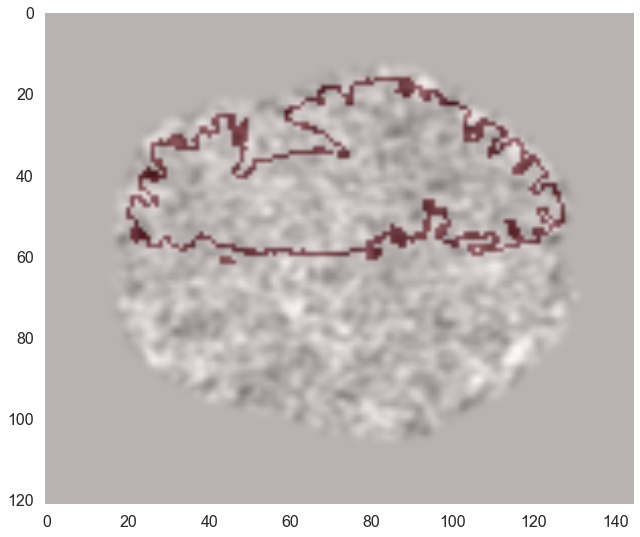

In [34]:
# plot the fake sampling on top of the volume
s=50
sns.set_style('dark')
plt.imshow(rest_data[:,:,s, 0], cmap='gray')
plt.imshow(fake[:,:,s], cmap='Reds', alpha=0.5)

Sample resting state data on mesh and average within rois

In [35]:
# actually sampling the resting state data (here on the low resolution mesh for speed)
idx = np.asarray(np.round(v_simple/dim), dtype='int64')
rest_mesh = rest_data[idx[:,0],idx[:,1],idx[:,2]]

In [36]:
# averaging within parcellation rois
label_data = np.empty((int(labels.max()+1), rest_mesh.shape[1]))
for l in range(int(labels.max()+1)):
    patch = np.where(labels==l)[0]
    patch_data = rest_mesh[patch]
    patch_mean = np.mean(patch_data, axis=0)
    label_data[l] = patch_mean

View the results for one label at a time

In [48]:
# plot timeseries, average and labels for single label
l = 6

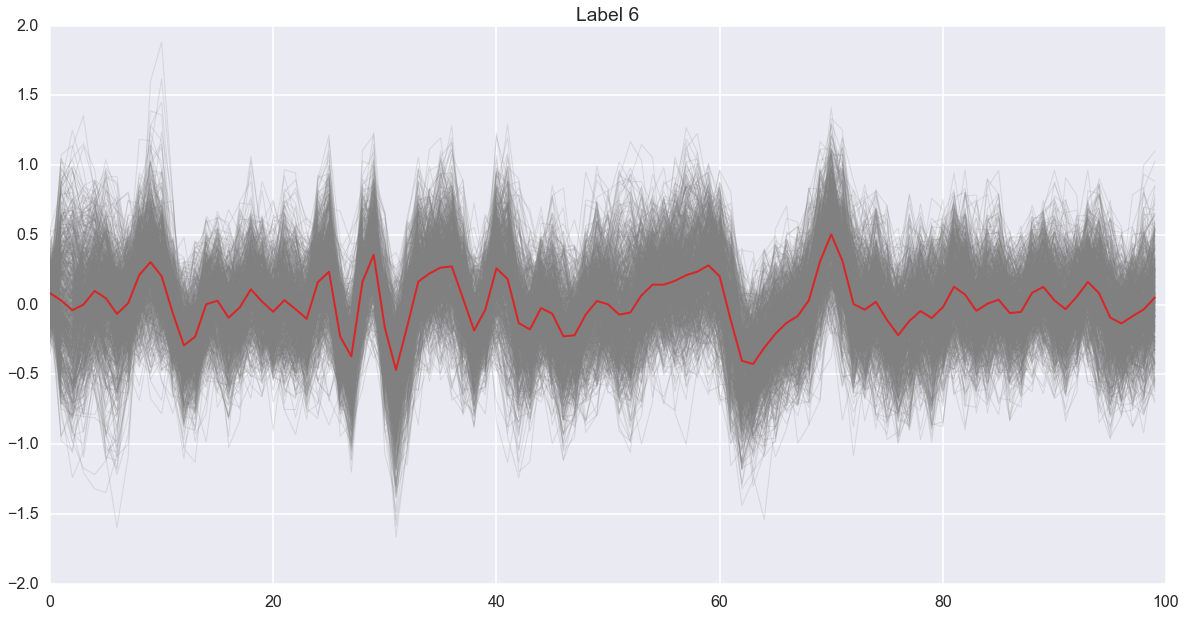

In [49]:
sns.set_context('poster')
sns.set_style('darkgrid')
fig =plt.figure(figsize=(20,10))
for i in range(np.where(labels==l)[0].shape[0]):
    plt.plot(rest_mesh[np.where(labels==l)[0][i]], color='gray', alpha=0.2, lw=1)
plt.plot(label_data[l], label='mean', color='r', lw=2, alpha=0.7)
plt.title('Label %s'%(l))

Where is this data coming from?

In [50]:
single_label = np.zeros_like(labels)
single_label[np.where(labels==l)[0]]=1

In [51]:
# this is a variant of the nilearn function with less overhead and more parameter flexibility
# https://github.com/juhuntenburg/brainsurfacescripts/blob/master/plotting.py
from plotting import plot_surf_stat_map

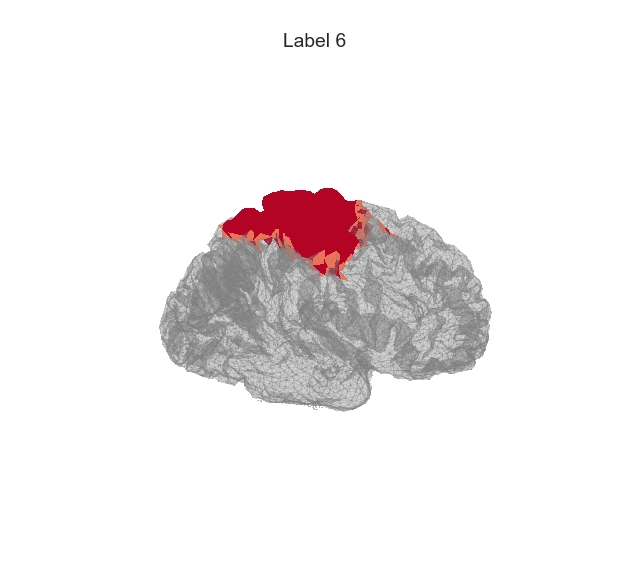

In [56]:
sns.set_style('white')
plot = plot_surf_stat_map(v_simple, f_simple, stat_map=single_label, elev=-160, threshold=0.5, alpha=0.2, figsize=(11,10))
plt.title('Label %s'%str(l))

### Take a walk on the surface

http://nbviewer.ipython.org/github/juhuntenburg/myelinconnect/blob/master/notebooks/path_windows.ipynb